In [23]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import imageio
import numpy as np
import warnings
import torch
from torch import nn
import torch.optim as opt

In [24]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

model = load_model('model_full_fold.h5')

In [25]:
def get_tracking_and_plays(filepath):
    """
    Return a dataframe containing cleaned tracking data joined with the plays data
    """
    tracking = pd.read_csv(filepath)
    plays = pd.read_csv("plays.csv")
    tracking = tracking[tracking['playId'].isin(tracking[tracking['event'] != 'fumble']['playId'].unique())]
    plays = plays[plays['playNullifiedByPenalty'] == 'N']

    tracking.loc[tracking['playDirection'] == 'left', 'x'] = 120 - tracking.loc[tracking['playDirection'] == 'left', 'x']
    tracking.loc[tracking['playDirection'] == 'left', 'y'] = (160/3) - tracking.loc[tracking['playDirection'] == 'left', 'y']
    tracking.loc[tracking['playDirection'] == 'left', 'dir'] += 180
    tracking.loc[tracking['dir'] > 360, 'dir'] -= 360
    tracking.loc[tracking['playDirection'] == 'left', 'o'] += 180
    tracking.loc[tracking['o'] > 360, 'o'] -= 360

    tracking_with_plays = tracking.merge(plays, on=['gameId', 'playId'], how='left')

    tracking_with_plays['is_on_offense'] = tracking_with_plays['club'] == tracking_with_plays['possessionTeam']
    tracking_with_plays['is_on_defence'] = tracking_with_plays['club'] == tracking_with_plays['defensiveTeam']
    tracking_with_plays['is_ballcarrier'] = tracking_with_plays['ballCarrierId'] == tracking_with_plays['nflId']

    end_frame = tracking_with_plays[tracking_with_plays['event'].isin(['tackle', 'out_of_bounds'])].groupby('playId')['frameId'].min().reset_index()
    end_frame.rename(columns={'frameId': 'frameId_end'}, inplace=True)

    start_frame = tracking_with_plays[tracking_with_plays['event'].isin(['run', 'lateral', 'run_pass_option', 'handoff', 'pass_arrived'])].groupby('playId')['frameId'].min().reset_index()
    start_frame.rename(columns={'frameId': 'frameId_start'}, inplace=True)

    tracking_with_plays = tracking_with_plays.merge(end_frame, on='playId', how='left')
    tracking_with_plays = tracking_with_plays.merge(start_frame, on='playId', how='left')

    tracking_with_plays = tracking_with_plays[(tracking_with_plays['frameId'] <= tracking_with_plays['frameId_end']) &
                                              (tracking_with_plays['frameId'] >= tracking_with_plays['frameId_start'])]

    return tracking_with_plays

In [4]:
tracking_with_plays = get_tracking_and_plays('tracking_week_1.csv')

In [26]:
def create_feature_tensor(feature_df):
    """
    Convert the input frame_df to a 4D tensor.
        - The first dimension is the frame
        - The second dimension is the index of the current player
        - The third dimension is the index of the relative player
    """
    tensor_shape = (feature_df.groupby(['gameId', 'playId', 'frameId']).ngroups, 10, 11, 10)
    input_tensor = np.zeros(tensor_shape)
    cur_count = 0
    for game_id, game_group in feature_df.groupby('gameId'):
        for play_id, play_group in game_group.groupby('playId'):
            for frame_id, frame_group in play_group.groupby('frameId'):
                offense = frame_group[(frame_group['is_on_offense']) & (~frame_group['is_ballcarrier'])]
                defence = frame_group[frame_group['is_on_defence']]
                ballcarrier = frame_group[frame_group['is_ballcarrier']]
                ballcarrier_sx = ballcarrier.s * np.cos(np.deg2rad(ballcarrier.dir))
                ballcarrier_sy = ballcarrier.s * np.sin(np.deg2rad(ballcarrier.dir))
                for i, def_player in enumerate(defence.itertuples()):
                    def_player_sx = def_player.s * np.cos(np.deg2rad(def_player.dir))
                    def_player_sy = def_player.s * np.sin(np.deg2rad(def_player.dir))
                    for j, off_player in enumerate(offense.itertuples()):
                        off_player_sx = off_player.s * np.cos(np.deg2rad(off_player.dir))
                        off_player_sy = off_player.s * np.sin(np.deg2rad(off_player.dir))
                        input_tensor[cur_count, 0, i, j] = off_player.x - def_player.x
                        input_tensor[cur_count, 1, i, j] = off_player.y - def_player.y
                        input_tensor[cur_count, 2, i, j] = def_player_sx
                        input_tensor[cur_count, 3, i, j] = def_player_sy
                        input_tensor[cur_count, 4, i, j] = def_player_sx - ballcarrier_sx
                        input_tensor[cur_count, 5, i, j] = def_player_sy - ballcarrier_sy
                        input_tensor[cur_count, 6, i, j] = def_player.x - ballcarrier.x
                        input_tensor[cur_count, 7, i, j] = def_player.y - ballcarrier.y
                        input_tensor[cur_count, 8, i, j] = off_player_sx - def_player_sx
                        input_tensor[cur_count, 9, i, j] = off_player_sy - def_player_sy
                cur_count += 1
    return input_tensor

In [59]:
import numpy as np

def change_distance(df, displayName, amount):
    df['sx'] = df['s'] * np.cos(np.deg2rad(df['dir']))
    df['sy'] = df['s'] * np.sin(np.deg2rad(df['dir']))

    filtered_df = df[df['displayName'] == displayName].copy()
    filtered_df['px'] = filtered_df['x'].shift(1)
    filtered_df['pxs'] = filtered_df['sx'].shift(1)
    filtered_df['py'] = filtered_df['y'].shift(1)
    filtered_df['psy'] = filtered_df['sy'].shift(1)

    for index, row in filtered_df.iterrows():
        if pd.isna(row['px']) or pd.isna(row['pxs']) or pd.isna(row['py']) or pd.isna(row['psy']):
            continue

        df.at[index, 'x'] = row['px'] + amount * row['pxs']
        df.at[index, 'y'] = row['py'] + amount * row['psy']

    return df

In [60]:
def compare_yard_prediction(tracking_with_plays, displayName, gameId, playId, amount):
  play_info = tracking_with_plays.loc[(tracking_with_plays['playId'] == playId) & (tracking_with_plays['gameId'] == gameId)]
  original_prediction = model.predict(create_feature_tensor(play_info))
  changed_play_info = change_distance(play_info, displayName, amount)
  changed_prediction = model.predict(create_feature_tensor(changed_play_info))
  prediction_difference = original_prediction - changed_prediction
  results = pd.DataFrame({
        'Original Prediction': original_prediction.flatten(),
        'Changed Prediction': changed_prediction.flatten(),
        'Prediction Difference': prediction_difference.flatten()
    })
  return results

In [69]:
compare_yard_prediction(tracking_with_plays, 'Troy Hill', 2022090800, 167, 0.1)

/var/folders/pq/qr32tkk90n7361gslj40w8j4tyz0cb/T/ipykernel_90442/1026185271.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  input_tensor[cur_count, 4, i, j] = def_player_sx - ballcarrier_sx
/var/folders/pq/qr32tkk90n7361gslj40w8j4tyz0cb/T/ipykernel_90442/1026185271.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  input_tensor[cur_count, 5, i, j] = def_player_sy - ballcarrier_sy
/var/folders/pq/qr32tkk90n7361gslj40w8j4tyz0cb/T/ipykernel_90442/1026185271.py:31: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  input_tensor[cur_count, 6, i, j] = def_player.x - ballcarrier.x
/var/folders/pq/qr32tkk90n7361gslj40w8j4tyz0cb/T/ipykernel_90442/1026185271.py:32: FutureWarning: Calling float on a sin

1/1 [==============================] - 0s 16ms/step


/var/folders/pq/qr32tkk90n7361gslj40w8j4tyz0cb/T/ipykernel_90442/348072.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sx'] = df['s'] * np.cos(np.deg2rad(df['dir']))
/var/folders/pq/qr32tkk90n7361gslj40w8j4tyz0cb/T/ipykernel_90442/348072.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sy'] = df['s'] * np.sin(np.deg2rad(df['dir']))
/var/folders/pq/qr32tkk90n7361gslj40w8j4tyz0cb/T/ipykernel_90442/1026185271.py:29: FutureWarning: Calling float on a single element Series is deprecated and will 

1/1 [==============================] - 0s 15ms/step


,Original Prediction,Changed Prediction,Prediction Difference
0,7.877769,7.877769,0.000000
1,7.455855,7.564321,-0.108466
2,7.102976,7.211108,-0.108131
3,6.713350,6.844267,-0.130918
4,6.172524,6.277161,-0.104637
5,5.552455,5.638566,-0.086111
6,4.855257,4.939154,-0.083898
7,4.466314,4.548366,-0.082052
8,4.065531,4.137591,-0.072060
9,3.809845,3.881839,-0.071993


In [99]:
tracking_with_plays.loc[(tracking_with_plays['gameId']==2022090800) & (tracking_with_plays['playId']==56)]

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,...,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2,is_on_offense,is_on_defence,is_ballcarrier,frameId_end,frameId_start
1,2022090800,56,35472.0,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.0,BUF,left,31.530000,...,0.00442,NaN,NaN,NaN,NaN,True,False,False,18.0,2.0
2,2022090800,56,35472.0,Rodger Saffold,3,2022-09-08 20:24:05.400000,76.0,BUF,left,31.440000,...,0.00442,NaN,NaN,NaN,NaN,True,False,False,18.0,2.0
3,2022090800,56,35472.0,Rodger Saffold,4,2022-09-08 20:24:05.500000,76.0,BUF,left,31.360000,...,0.00442,NaN,NaN,NaN,NaN,True,False,False,18.0,2.0
4,2022090800,56,35472.0,Rodger Saffold,5,2022-09-08 20:24:05.599999,76.0,BUF,left,31.280000,...,0.00442,NaN,NaN,NaN,NaN,True,False,False,18.0,2.0
5,2022090800,56,35472.0,Rodger Saffold,6,2022-09-08 20:24:05.700000,76.0,BUF,left,31.200000,...,0.00442,NaN,NaN,NaN,NaN,True,False,False,18.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,2022090800,56,NaN,football,14,2022-09-08 20:24:06.500000,NaN,football,left,42.059998,...,0.00442,NaN,NaN,NaN,NaN,False,False,False,18.0,2.0
498,2022090800,56,NaN,football,15,2022-09-08 20:24:06.599999,NaN,football,left,41.919998,...,0.00442,NaN,NaN,NaN,NaN,False,False,False,18.0,2.0
499,2022090800,56,NaN,football,16,2022-09-08 20:24:06.700000,NaN,football,left,41.940002,...,0.00442,NaN,NaN,NaN,NaN,False,False,False,18.0,2.0
500,2022090800,56,NaN,football,17,2022-09-08 20:24:06.799999,NaN,football,left,41.830002,...,0.00442,NaN,NaN,NaN,NaN,False,False,False,18.0,2.0


In [65]:
create_feature_tensor(tracking_with_plays.loc[(tracking_with_plays['playId'] == 80) & (tracking_with_plays['gameId'] == 2022090800)])[0][0][10]

/var/folders/pq/qr32tkk90n7361gslj40w8j4tyz0cb/T/ipykernel_90442/1026185271.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  input_tensor[cur_count, 4, i, j] = def_player_sx - ballcarrier_sx
/var/folders/pq/qr32tkk90n7361gslj40w8j4tyz0cb/T/ipykernel_90442/1026185271.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  input_tensor[cur_count, 5, i, j] = def_player_sy - ballcarrier_sy
/var/folders/pq/qr32tkk90n7361gslj40w8j4tyz0cb/T/ipykernel_90442/1026185271.py:31: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  input_tensor[cur_count, 6, i, j] = def_player.x - ballcarrier.x
/var/folders/pq/qr32tkk90n7361gslj40w8j4tyz0cb/T/ipykernel_90442/1026185271.py:32: FutureWarning: Calling float on a sin

array([ -9.19,  -7.56,   6.8 ,  -8.85,   2.68,  -9.48,  -0.36, -12.35,
         3.22, -12.44])

In [10]:
import matplotlib.pyplot as plt

def plot_prediction_difference(df, gameId, playId, amount, player1, player2):
    player1_pred = compare_yard_prediction(df, player1, gameId, playId, amount)
    player2_pred = compare_yard_prediction(df, player2, gameId, playId, amount)
    pred_difference = player2_pred['Changed Prediction'] - player1_pred['Changed Prediction']
    frames = range(len(player1_pred))
    plt.figure(figsize=(10, 6))
    plt.plot(frames, pred_difference, color='blue')
    plt.title('Yard Prediction Differences per Frame on Projected Movements')
    plt.xlabel('Frame')
    plt.ylabel('Yard Prediction')
    note = f"Difference is {player2}'s - {player1}'s predicted yards"
    plt.text(0.5, 0.01, note, transform=plt.gca().transAxes, fontsize=9, va='bottom', ha='center')
    plt.grid(True)
    plt.show()

/var/folders/pq/qr32tkk90n7361gslj40w8j4tyz0cb/T/ipykernel_90442/1026185271.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  input_tensor[cur_count, 4, i, j] = def_player_sx - ballcarrier_sx
/var/folders/pq/qr32tkk90n7361gslj40w8j4tyz0cb/T/ipykernel_90442/1026185271.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  input_tensor[cur_count, 5, i, j] = def_player_sy - ballcarrier_sy
/var/folders/pq/qr32tkk90n7361gslj40w8j4tyz0cb/T/ipykernel_90442/1026185271.py:31: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  input_tensor[cur_count, 6, i, j] = def_player.x - ballcarrier.x
/var/folders/pq/qr32tkk90n7361gslj40w8j4tyz0cb/T/ipykernel_90442/1026185271.py:32: FutureWarning: Calling float on a sin

1/1 [==============================] - 0s 18ms/step


/var/folders/pq/qr32tkk90n7361gslj40w8j4tyz0cb/T/ipykernel_90442/77074295.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sx'] = df['s'] * np.cos(np.deg2rad(df['dir']))
/var/folders/pq/qr32tkk90n7361gslj40w8j4tyz0cb/T/ipykernel_90442/77074295.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sy'] = df['s'] * np.sin(np.deg2rad(df['dir']))
/var/folders/pq/qr32tkk90n7361gslj40w8j4tyz0cb/T/ipykernel_90442/1026185271.py:29: FutureWarning: Calling float on a single element Series is deprecated and w

1/1 [==============================] - 0s 16ms/step


/var/folders/pq/qr32tkk90n7361gslj40w8j4tyz0cb/T/ipykernel_90442/77074295.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sx'] = df['s'] * np.cos(np.deg2rad(df['dir']))
/var/folders/pq/qr32tkk90n7361gslj40w8j4tyz0cb/T/ipykernel_90442/77074295.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sy'] = df['s'] * np.sin(np.deg2rad(df['dir']))
/var/folders/pq/qr32tkk90n7361gslj40w8j4tyz0cb/T/ipykernel_90442/1026185271.py:29: FutureWarning: Calling float on a single element Series is deprecated and w

1/1 [==============================] - 0s 16ms/step


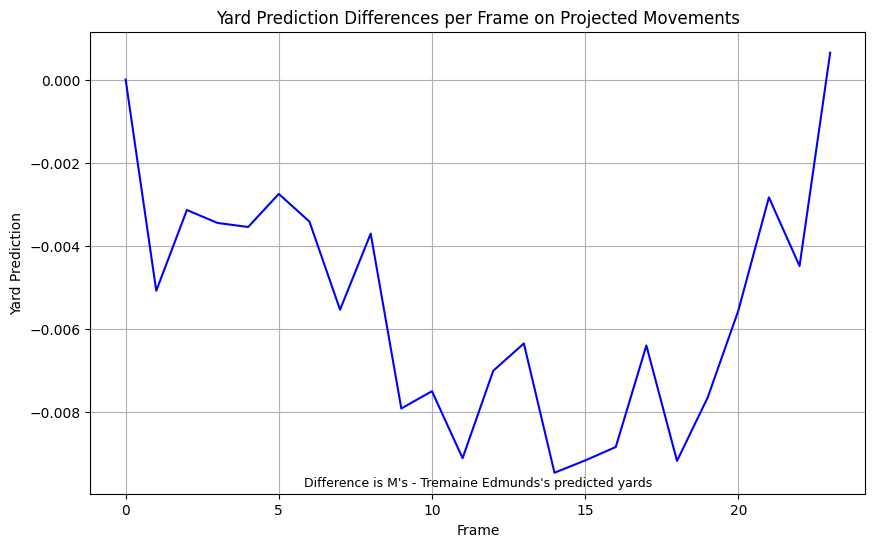

In [11]:
plot_prediction_difference(tracking_with_plays, 2022090800, 818, 0.1, 'Tremaine Edmunds', 'M')

In [98]:
plays=pd.read_csv('plays.csv')
games=pd.read_csv('games.csv')
tracking1 = get_tracking_and_plays('tracking_week_1.csv')
tracking2 = get_tracking_and_plays('tracking_week_2.csv')
tracking3 = get_tracking_and_plays('tracking_week_3.csv')
tracking4 = get_tracking_and_plays('tracking_week_4.csv')
tracking5 = get_tracking_and_plays('tracking_week_5.csv')
tracking6 = get_tracking_and_plays('tracking_week_6.csv')
tracking7 = get_tracking_and_plays('tracking_week_7.csv')
tracking8 = get_tracking_and_plays('tracking_week_8.csv')
tracking9 = get_tracking_and_plays('tracking_week_9.csv')

In [81]:
def get_tracking(week_num):
    if week_num==1:
        return tracking1
    elif week_num==2:
        return tracking2
    elif week_num==3:
        return tracking3
    elif week_num==4:
        return tracking4
    elif week_num==5:
        return tracking5
    elif week_num==6:
        return tracking6
    elif week_num==7:
        return tracking7
    elif week_num==8:
        return tracking8
    else:
        return tracking9

In [89]:
warnings.filterwarnings('ignore')
distinct_plays=plays[['gameId', 'playId']]
results_dict={}

counter=0
for i, row in distinct_plays.iterrows():
    week_number=int(games.loc[games['gameId']==row['gameId']]['week'])
    tracking=get_tracking(week_number)
    players=tracking.loc[(tracking['gameId']==row['gameId']) & (tracking['playId']==row['playId']) & (tracking['is_on_defence']==True)]['displayName'].unique()
    for j in players:
        final_df=compare_yard_prediction(tracking, j, int(row['gameId']), int(row['playId']), 0.1)
        cumulative_impact=sum(final_df['Prediction Difference'])
        if j in results_dict:
            results_dict[j]+=cumulative_impact
        else:
            results_dict[j]=cumulative_impact
    counter+=1
    if counter>5:
        break
        

1/1 [==============================] - 0s 16ms/step


In [90]:
results_dict

{'Lavonte David': -0.03317782282829285,
 'Shaquil Barrett': -0.08553335070610046,
 'Rakeem Nunez-Roches': 0.02635619044303894,
 'Keanu Neal': 0.07783582806587219,
 'Deadrin Senat': -0.030443906784057617,
 'Devin White': -0.12484666705131531,
 'Jamel Dean': -0.03244203329086304,
 'Mike Edwards': -0.06665235757827759,
 'Antoine Winfield': 0.06751951575279236,
 'Joe Tryon': 0.004233449697494507,
 'Zyon McCollum': 0.0,
 'Eli Apple': -0.7011548280715942,
 'Vonn Bell': -0.7090435028076172,
 'Mike Hilton': 0.061215758323669434,
 'Chidobe Awuzie': 0.2800303101539612,
 'Trey Hendrickson': 2.7556572556495667,
 'Josh Tupou': 1.2299737334251404,
 'Jessie Bates': 0.5983547568321228,
 'Sam Hubbard': 0.4566078186035156,
 'Germaine Pratt': -3.858944058418274,
 'Logan Wilson': 0.40235501527786255,
 'Zachary Carter': 0.0,
 'Khalil Mack': -0.4416239261627197,
 'Bryce Callahan': 0.06708759069442749,
 'Joey Bosa': -0.0331803560256958,
 'Austin Johnson': 0.42829662561416626,
 'Michael Davis': -0.53510439395

In [112]:
def get_prediction_difference(tracking_with_plays, gameId, playId):
  play_info = tracking_with_plays.loc[(tracking_with_plays['playId'] == playId) & (tracking_with_plays['gameId'] == gameId)]
  first_coord_football=float(play_info[(play_info['frameId']==play_info['frameId_start']) & (play_info['displayName']=='football')]['x'])
  last_coord_football=float(play_info[(play_info['frameId']==play_info['frameId_end']) & (play_info['displayName']=='football')]['x'])
  original_prediction = model.predict(create_feature_tensor(play_info))
  actual_yards=last_coord_football-first_coord_football
  ball_carrier=tracking_with_plays.iloc[0]['ballCarrierDisplayName']
  defense_name=tracking_with_plays.iloc[0]['defensiveTeam']
  return actual_yards-original_prediction[0][0], ball_carrier, defense_name

In [113]:
get_prediction_difference(tracking1, 2022090800, 818)

1/1 [==============================] - 0s 10ms/step


(1.9375271797180602, 'Stefon Diggs', 'LA')

In [117]:
warnings.filterwarnings('ignore')
distinct_plays=plays[['gameId', 'playId']]
team_results={}

counter=0
for i, row in distinct_plays.iterrows():
    week_number=int(games.loc[games['gameId']==row['gameId']]['week'])
    tracking=get_tracking(week_number)
    try:
        tuple_vals=get_prediction_difference(tracking, row['gameId'], row['playId'])
        if tuple_vals[1] in team_results:
            team_results[tuple_vals[1]]+=tuple_vals[0]
        else:
            team_results[tuple_vals[1]]=tuple_vals[0]
        if tuple_vals[2] in team_results:
            team_results[tuple_vals[2]]-=tuple_vals[0]
        else:
            team_results[tuple_vals[2]]=tuple_vals[0]*-1
    except:
        print(row['gameId'], row['playId'])

team_results

1/1 [==============================] - 0s 13ms/step
2022103001 1415
2022100211 1790
1/1 [==============================] - 0s 12ms/step
2022100202 1369
1/1 [==============================] - 0s 9ms/step
2022103001 983
2022091901 1683
1/1 [==============================] - 0s 10ms/step
2022091500 2359
1/1 [==============================] - 0s 10ms/step
2022102300 2314
2/2 [==============================] - 0s 3ms/step
2022102700 366
2/2 [==============================] - 0s 2ms/step
2022092510 3686
1/1 [==============================] - 0s 9ms/step
2022102306 916
1/1 [==============================] - 0s 9ms/step
2022091100 594
1/1 [==============================] - 0s 9ms/step
2022091112 611
1/1 [==============================] - 0s 10ms/step
2022102303 1658
1/1 [==============================] - 0s 11ms/step
2022091108 3063
1/1 [==============================] - 0s 9ms/step
2022101611 2327
1/1 [==============================] - 0s 9ms/step
2022100205 4387
1/1 [========================